In [49]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import numpy as np
import analysis_functions as af
import analysis_system_level as asl
import itertools
import copy

from collections import defaultdict as ddict
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

This notebook loads the score dict and performs analysis corresponding to the experiments in the paper, for either dataset 'CNNDM Ext', 'CNNDM Abs' or 'CNNDM Mix'. Accordingly set variable below.

In [52]:
mode = 'cnndm_mix' # allowed: 'cnndm_abs', 'cnndm_ext', 'cnndm_mix'
assert mode in ['cnndm_abs', 'cnndm_ext', 'cnndm_mix']

abs_sd_path = "../data/score_dicts/abstractive_summaries_score_dict.pkl"
ext_sd_path = "../data/score_dicts/extractive_summaries_score_dict.pkl"

In [53]:
# set mode-based variables: sd (score dict), kvalues (for exp ii), splits (for expt iii)
if mode == 'cnndm_abs':    
    sd = af.get_pickle(abs_sd_path)
    kvalues = [15, 14, 12, 10, 8, 6, 4] 
    splits = [0, 5, 10] 
elif mode == 'cnndm_ext':
    sd = af.get_pickle(ext_sd_path)
    kvalues = [10, 8, 6, 4]
    splits = [0, 3, 6]
else: # mix
    sd_abs = af.get_pickle(abs_sd_path)
    sd_ext = af.get_pickle(ext_sd_path)
    sd = copy.deepcopy(sd_abs)
    for doc_id in sd:
        isd_sota_ext = sd_ext[doc_id]
        isd_sota_ext['system_summaries']['bart_out_ext.txt'] = isd_sota_ext['system_summaries']['bart_out.txt']
        sd[doc_id]['system_summaries'].update(isd_sota_ext['system_summaries'])
    kvalues = [25, 20, 18, 16, 14, 12, 10, 8, 6, 4]
    splits = [0, 5, 10, 15, 20]

## Exploring the scores dict
### Print score ranges

In [54]:
af.print_score_ranges(sd)

                          min    25-perc    median    75-perc      max     mean
--------------------  -------  ---------  --------  ---------  -------  -------
bert_f_score          -0.3518     0.1878    0.2743     0.3545   0.9326   0.2726
bert_precision_score  -0.2548     0.1439    0.2325     0.3289   0.9430   0.2391
bert_recall_score     -0.4593     0.2092    0.3081     0.4013   0.9219   0.3056
js-2                  -0.6931    -0.6075   -0.5563    -0.4993  -0.1201  -0.5454
litepyramid_recall     0.0000     0.2292    0.3125     0.3750   0.9375   0.3097
mover_score            0.0082     0.2230    0.2745     0.3338   0.7542   0.2821
rouge_1_f_score        0.0961     0.3607    0.4324     0.5088   0.9048   0.4381
rouge_1_precision      0.1000     0.3148    0.3830     0.4758   0.9412   0.4001
rouge_1_recall         0.0926     0.4064    0.5094     0.6154   0.9600   0.5119
rouge_2_f_score        0.0000     0.1157    0.1831     0.2617   0.8293   0.2007
rouge_2_precision      0.0000     0.1020

### How many documents?

In [55]:
len(sd)

100

### How many summaries per document?

In [39]:
print(np.mean([len(d['system_summaries']) for d in sd.values()]))

10.0


### What metrics found for each document?

In [40]:
mlist = af.get_metrics_list(sd)
mlist

['bert_f_score',
 'bert_precision_score',
 'bert_recall_score',
 'js-2',
 'litepyramid_recall',
 'mover_score',
 'rouge_1_f_score',
 'rouge_1_precision',
 'rouge_1_recall',
 'rouge_2_f_score',
 'rouge_2_precision',
 'rouge_2_recall',
 'rouge_l_f_score',
 'rouge_l_precision',
 'rouge_l_recall',
 'sms',
 'wms']

# Experiments

In [41]:
# list of metrics used in experiment
mlist = ['bert_recall_score', 'mover_score', 'wms', 'sms', 'rouge_1_recall', 'rouge_2_recall', 'rouge_l_recall', 'js-2', 
         'litepyramid_recall']

## Exp. IV: Summary level analysis

In [42]:
np.set_printoptions(precision=4)

Prints a matrix of Pearson's r values between each metric pair. 
Read this as a table where the column labels (list of metrics printed in the first line of output) are also the row labels from top to bottom.

In [43]:
metrics = mlist
af.print_ktau_matrix(metrics, percentile=[(0, 100)], sd=sd, cutoff_metric='litepyramid_recall', y_type='pearson')

['bert_recall_score', 'mover_score', 'wms', 'sms', 'rouge_1_recall', 'rouge_2_recall', 'rouge_l_recall', 'js-2', 'litepyramid_recall']
[[0.     0.819  0.6398 0.4573 0.7993 0.7887 0.7797 0.7726 0.6827]]

[[0.     0.     0.7998 0.4685 0.6329 0.7746 0.6974 0.8465 0.7483]]

[[0.     0.     0.     0.6755 0.5818 0.7407 0.6022 0.8075 0.4667]]

[[0.     0.     0.     0.     0.7409 0.7306 0.7703 0.6256 0.6019]]

[[0.     0.     0.     0.     0.     0.8602 0.955  0.7072 0.7738]]

[[0.     0.     0.     0.     0.     0.     0.8838 0.9041 0.705 ]]

[[0.     0.     0.     0.     0.     0.     0.     0.7442 0.6995]]

[[0.     0.     0.     0.     0.     0.     0.     0.     0.5712]]

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]]

total 2041/3600.0 = 56.69444444444444% values ignored


## Exp-II: Evaluating Top-k Systems

### prints pearson correlations for each metric, for different k values

25
{'litepyramid_recall_wms': 0.9853195876621872}

20
{'litepyramid_recall_mover_score': 0.7929642354521256, 'litepyramid_recall_wms': 0.5697600286389322, 'litepyramid_recall_sms': 0.13752270821657128}

18
{'litepyramid_recall_mover_score': 0.9212747960770103, 'litepyramid_recall_wms': 0.41534830251531346, 'litepyramid_recall_sms': 0.6461487711487377, 'litepyramid_recall_js-2': 0.09091913719177554}

16
{'litepyramid_recall_mover_score': 0.7791901516046325, 'litepyramid_recall_wms': 0.2352783543761966, 'litepyramid_recall_sms': 0.7674063366628605, 'litepyramid_recall_js-2': 0.12730026067038266}

14
{'litepyramid_recall_mover_score': 0.3306332534284871, 'litepyramid_recall_wms': 0.08735756654623347, 'litepyramid_recall_sms': 0.13585616005061163, 'litepyramid_recall_js-2': 0.13459906910537034}

12
{'litepyramid_recall_mover_score': 0.07433745476139106, 'litepyramid_recall_wms': 0.6810160821559108, 'litepyramid_recall_sms': 0.6557089442162636}

semsim_out.txt 0.3684374999999999
bart_out.tx

Text(0.5, 0, 'top k systems according to litepyramid_recall')

Text(0, 0.5, 'pearson correlation between different metric pairs')

(-1, 1)

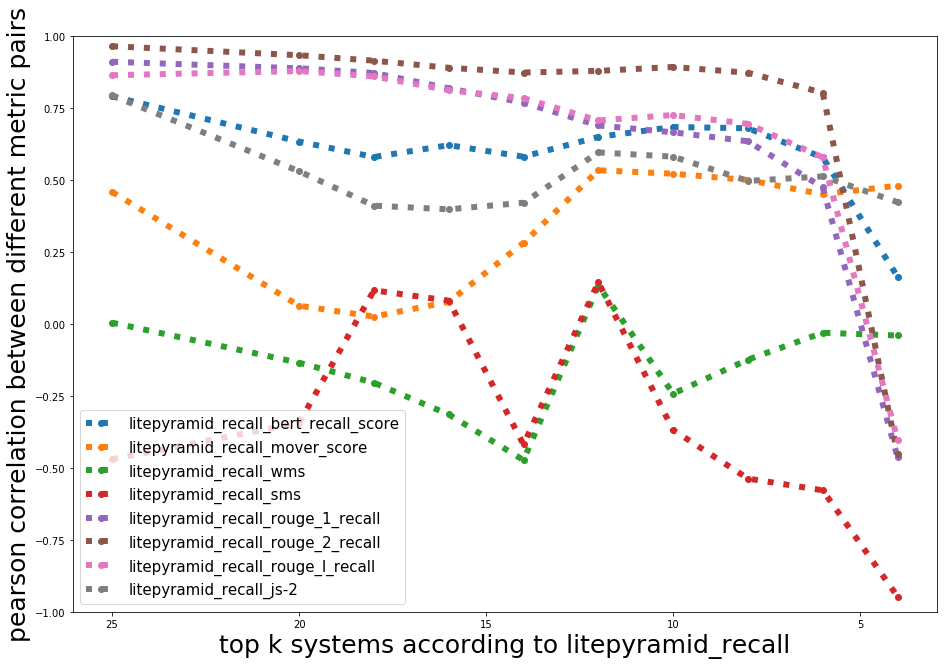

In [56]:
# plot k vs disagreements

all_pairs = [('litepyramid_recall', m) for m in mlist if m != 'litepyramid_recall']
systems = asl.get_system_level_scores(sd, mlist, agg='mean')
sorting_metric = 'litepyramid_recall'
correlation_method = 'pearson'

y = ddict(list)
for k in kvalues:
    top_ksystems = asl.get_topk(systems, k, metric=sorting_metric)
    if k == 10:
        for sys, scores in top_ksystems.items():
            print(sys, scores['litepyramid_recall'])
#     print(k, top_ksystems.keys())
    corr, pval = asl.get_correlation(top_ksystems, metric_pairs=all_pairs, method=correlation_method)
    for key in corr:
        y[key].append(corr[key])
        
    print(k)
    print({m: p for m, p in pval.items() if p > 0.05})
    print()
        
data = {
    'x': kvalues,
    **y,
}
labels = list(y.keys())

ax = plt.axes([0, 0, 2, 2])
lines = []
for label in labels:
    lines.append(ax.plot('x', label, data=data, linewidth=6.0, marker='o',
                         linestyle=':' if 'pyramid' in label else None))
plt.gca().invert_xaxis()
ax.legend(prop={'size': 15})
ax.set_xlabel(f"top k systems according to {sorting_metric}", fontsize=25)
ax.set_ylabel(f"{correlation_method} correlation between different metric pairs", fontsize=25)
plt.ylim(-1, 1)

In [16]:
for i in range(len(data['x'])):
    print('\t'.join(['{:.3f}'.format(data['x'][i])] + ['{:.3f}'.format(data[key][i]) for key in y.keys()]))

15.000	0.819	0.783	0.373	-0.381	0.889	0.979	0.798	0.864
14.000	0.826	0.791	0.344	-0.556	0.851	0.972	0.783	0.838
12.000	0.753	0.678	0.179	-0.380	0.833	0.968	0.818	0.789
10.000	0.678	0.556	0.004	-0.328	0.882	0.978	0.879	0.731
8.000	0.622	0.445	-0.021	0.047	0.887	0.974	0.877	0.646
6.000	0.664	0.361	-0.066	0.218	0.861	0.977	0.859	0.632
4.000	0.989	0.442	-0.275	-0.572	0.870	0.991	0.889	0.625


## Exp. I : System-level analysis: Evaluating All Systems

### Significance testing using William’s test

#### prints williams tests results to local file

In [57]:
#  Write results for william's test to file

In [58]:
W_DATAPATH = "../data/"
human_scores_fp = W_DATAPATH + mode +'_human_scores.tsv' # change 'abs' to 'ext' for extractive
metric_scores_fp = W_DATAPATH + mode + '_metric_scores.tsv' # change 'abs' to 'ext' for extractive

In [59]:
header = 'METRIC\tLP\tTESTSET\tSYSTEM\tSCORE'

In [60]:
systems = asl.get_system_level_scores(sd, mlist, agg='mean')
len(systems)

25

In [61]:
# systems

In [62]:
with open(human_scores_fp, 'w') as f:
    f.write(header + '\n')
    for sys_name in systems:
        _ = f.write(f"HUMAN\ten-en\tcnndm\t{sys_name}\t{systems[sys_name]['litepyramid_recall']}\n")

31

In [63]:
with open(metric_scores_fp, 'w') as f:
    f.write(header + '\n')
    for m in mlist:
        if m == 'litepyramid_recall':
            continue
        for sys_name in systems:
            _ = f.write(f"{m}\ten-en\tcnndm\t{sys_name}\t{systems[sys_name][m]}\n")

31

## Exp. III: Bootstrap Resampling

### prints results corresponding to expt iii

In [64]:
systems = asl.get_system_level_scores(sd, mlist, agg='none')
# systems
sys_names = list(systems.keys())
all_system_pairs = list(itertools.combinations(sys_names, 2))

In [65]:
from random import choices

In [66]:
def get_predictions_br(system_pairs, systems, metric):
    preds = {}
    for pair in system_pairs:
        sys1 = systems[pair[0]][metric]
        sys2 = systems[pair[1]][metric]
        n = len(sys1)
        points = [i for i in range(0, n)]
        is_better = 0
        for i in range(1000):
            sample = choices(points, k=n)
            sys1_ = [sys1[p] for p in points]
            sys2_ = [sys2[p] for p in points]
            if np.mean(sys1_) > np.mean(sys2_):
                is_better += 1
                
        if is_better/1000 >= 0.95:
            preds[pair] = 0 # pair[0] is better
        elif is_better/1000 <= 0.05:
            preds[pair] = 1 # pair[1] is better
        else:
            preds[pair] = 2 # can't say
    return preds

In [67]:
# print 1 if second metric is better than the first 
human_judgements = get_predictions_br(all_system_pairs, systems, 'litepyramid_recall')

In [68]:
human_judgements

{('presumm_out_trans_abs.txt', 'two_stage_rl_out.txt'): 1,
 ('presumm_out_trans_abs.txt', 'unilm_out_v2.txt'): 1,
 ('presumm_out_trans_abs.txt', 't5_out_large.txt'): 1,
 ('presumm_out_trans_abs.txt', 'presumm_out_ext_abs.txt'): 1,
 ('presumm_out_trans_abs.txt', 'ptr_generator_out_pointer_gen_cov.txt'): 0,
 ('presumm_out_trans_abs.txt', 'neusumm_out.txt'): 1,
 ('presumm_out_trans_abs.txt', 'bart_out.txt'): 1,
 ('presumm_out_trans_abs.txt', 'fast_abs_rl_out_rerank.txt'): 1,
 ('presumm_out_trans_abs.txt', 't5_out_11B.txt'): 1,
 ('presumm_out_trans_abs.txt', 'presumm_out_abs.txt'): 1,
 ('presumm_out_trans_abs.txt', 'bottom_up_out.txt'): 0,
 ('presumm_out_trans_abs.txt', 'unilm_out_v1.txt'): 1,
 ('presumm_out_trans_abs.txt', 't5_out_base.txt'): 1,
 ('presumm_out_trans_abs.txt', 'semsim_out.txt'): 1,
 ('presumm_out_trans_abs.txt', 'pnbert_out_lstm_pn_rl.txt'): 1,
 ('presumm_out_trans_abs.txt', 'refresh_out.txt'): 1,
 ('presumm_out_trans_abs.txt', 'heter_graph_out.txt'): 1,
 ('presumm_out_tra

In [ ]:
# print f1 scores
y_true = [human_judgements[pair] for pair in all_system_pairs]
metrics = mlist
for metric in metrics:
    metric_predictions = get_predictions_br(all_system_pairs, systems, metric)
    
    y_pred = [metric_predictions[pair] for pair in all_system_pairs]
    print(metric, f1_score(y_true, y_pred, average='weighted'))

bert_recall_score 0.8006260718549876
mover_score 0.6854144711018068
wms 0.5842687074829932
sms 0.5395857692322832
rouge_1_recall 0.873763963088878
rouge_2_recall 0.9365552965552966
rouge_l_recall 0.867552887364208
js-2 0.7880885482081893
